In [74]:
# !pip install -q torch_geometric
!pip install -q dgl #  export DGLBACKEND DGLBACKEND = pytorch

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.nn import Linear, Conv1d, RNN
from torch.utils.data import DataLoader, TensorDataset

import dgl
from dgl.nn import GraphConv

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [75]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
dataset = dgl.data.ChameleonDataset()
data = dataset[0]

train_idx = np.where(data.ndata['train_mask'].numpy())[0]
# val_idx = np.where(val_mask.numpy())[0]
# test_idx = np.where(data.ndata['test_mask'].numpy())[0]

train_graph = dgl.node_subgraph(data, train_idx)
train_feat = train_graph.ndata['feat']
train_label = train_graph.ndata['label']
# val_set = dgl.node_subgraph(g, val_idx)
# test_graph = dgl.node_subgraph(data, test_idx)
# test_feat = test_graph.ndata['feat']
# test_label = test_graph.ndata['label']

Done loading data from cached files.


###1\. Изучить статью о GCN по ссылке: https://nuancesprog.ru/p/18983/ в том числе изучить описание датасета, который используется в данной статье.

###2\. Скачать пример кода GCN из указанной статьи и проверить его работоспособность

###3\. Заменить в примере кода исходный датасет по карате клубу на любой другой датасет и решить задачу классификации (в новом датасете должны быть как минимум 4 категории сущностей, которые подлежат классификации).

In [ ]:
print(dataset)
print(f'Graph: {data}')
print('------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {data.ndata["feat"].shape[1]}')
print(f'Number of classes: {dataset.num_classes}')

Dataset("chameleon", num_graphs=1, save_path=/root/.dgl/chameleon_03d661d3)
Graph: Graph(num_nodes=2277, num_edges=36101,
      ndata_schemes={'feat': Scheme(shape=(2325,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'train_mask': Scheme(shape=(10,), dtype=torch.bool), 'val_mask': Scheme(shape=(10,), dtype=torch.bool), 'test_mask': Scheme(shape=(10,), dtype=torch.bool)}
      edata_schemes={})
------------
Number of graphs: 1
Number of features: 2325
Number of classes: 5


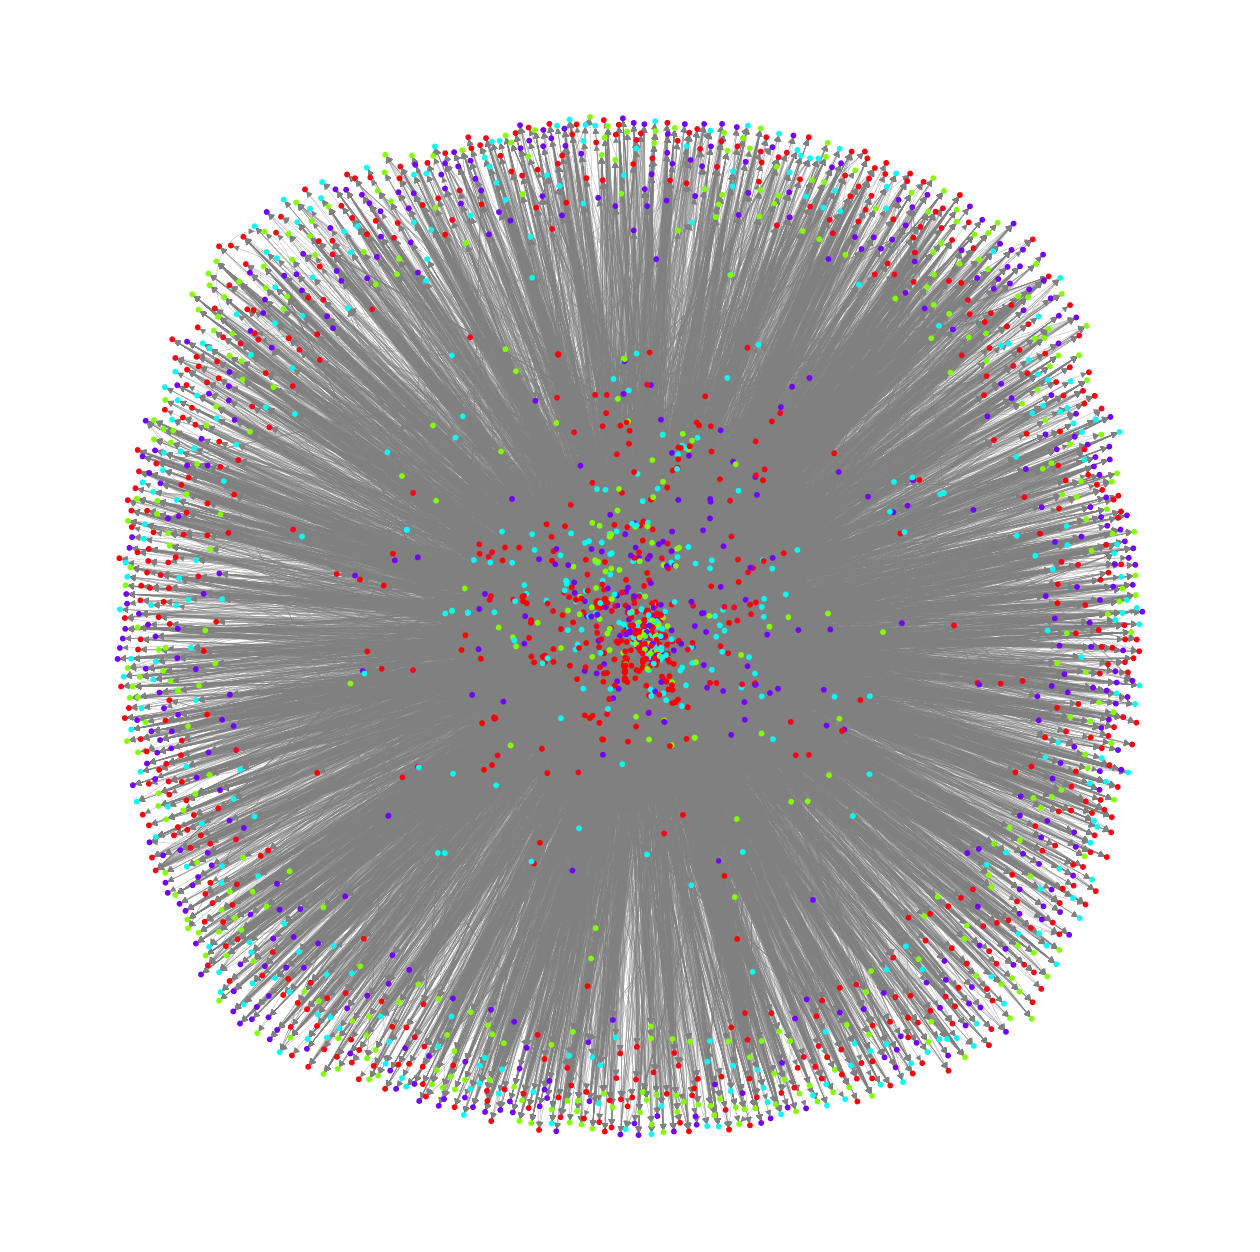

In [ ]:
# nx_g = dataset[0].to_networkx(node_attrs=['label', 'feat'])
# labels = data.ndata['label']

# plt.figure(figsize=(16,16))
# plt.axis('off')
# nx.draw_networkx(nx_g,
#                 pos=nx.spring_layout(nx_g, seed=37, iterations=30),
#                 with_labels=False,
#                 node_size=10,
#                 node_color=labels,
#                 cmap="hsv",
#                 width=0.2,
#                 edge_color="grey")
# plt.show()

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes, embed_dim=16, hid_dim=3):
        super(GCN, self).__init__()
        self.gcn = GraphConv(num_features, embed_dim, allow_zero_in_degree=True)
        self.conv = Conv1d(in_channels=embed_dim, out_channels=hid_dim, kernel_size=3, padding=1)
        self.fc_1 = Linear(hid_dim, num_classes)
        # self.fc_2 = Linear(32, 16)
        # self.fc_3 = Linear(4, num_classes)

    def forward(self, g, feat):
        emb = self.gcn(g, feat).relu()
        emb = self.conv(emb.permute(1, 0)).relu()
        out = self.fc_1(emb.permute(1, 0))
        # out = self.fc_2(out)
        # out = self.fc_3(out)
        return emb.permute(1, 0), out

In [ ]:
# model = GCN(num_features=data.ndata['feat'].shape[1], num_classes=dataset.num_classes)
# print(model)

# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.08)

# def accuracy(pred_y, y):
#     return (pred_y == y).sum() / len(y)

# # Data for animations
# embeddings = []
# losses = []
# accuracies = []
# outputs = []

# for epoch in range(101):

#     optimizer.zero_grad() # Clear gradients

#     emb, out = model(train_graph, train_feat) # Forward pass
#     loss = criterion(out, train_label) # Calculate loss function
#     acc = accuracy(out.argmax(dim=1), train_label) # Calculate accuracy

#     loss.backward() # Compute gradients
#     optimizer.step() # Tune parameters

#     # Store data for animations
#     embeddings.append(emb)
#     losses.append(loss)
#     accuracies.append(acc)
#     outputs.append(out.argmax(dim=1))

#     if epoch % 10 == 0:
#         print(f'Epoch {epoch:>3} | Loss: {loss:.2f} | Acc: {acc*100:.2f}%')

GCN(
  (gcn): GraphConv(in=2325, out=16, normalization=both, activation=None)
  (conv): Conv1d(16, 3, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc_1): Linear(in_features=3, out_features=5, bias=True)
)
Epoch   0 | Loss: 1.62 | Acc: 20.27%
Epoch  10 | Loss: 1.58 | Acc: 25.92%
Epoch  20 | Loss: 1.54 | Acc: 27.59%
Epoch  30 | Loss: 1.52 | Acc: 28.72%
Epoch  40 | Loss: 1.49 | Acc: 29.33%
Epoch  50 | Loss: 1.49 | Acc: 30.08%
Epoch  60 | Loss: 1.47 | Acc: 27.96%
Epoch  70 | Loss: 1.46 | Acc: 30.88%
Epoch  80 | Loss: 1.45 | Acc: 31.28%
Epoch  90 | Loss: 1.45 | Acc: 31.52%
Epoch 100 | Loss: 1.45 | Acc: 29.11%


In [ ]:
def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)

def run(embed_dim, hid_dim):
    print(f'Embed_dim = {embed_dim}, Hid_dim = {hid_dim}')

    model = GCN(num_features=data.ndata['feat'].shape[1], num_classes=dataset.num_classes, embed_dim=64, hid_dim=8)
    # print(model)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.08)

    # Data for animations
    embeddings = []
    losses = []
    accuracies = []
    outputs = []

    for epoch in range(101):

        optimizer.zero_grad() # Clear gradients

        emb, out = model(train_graph, train_feat) # Forward pass
        loss = criterion(out, train_label) # Calculate loss function
        acc = accuracy(out.argmax(dim=1), train_label) # Calculate accuracy

        loss.backward() # Compute gradients
        optimizer.step() # Tune parameters

        # Store data for animations
        embeddings.append(emb)
        losses.append(loss)
        accuracies.append(acc)
        outputs.append(out.argmax(dim=1))

        if epoch % 10 == 0:
            print(f'Epoch {epoch:>3} | Loss: {loss:.2f} | Acc: {acc*100:.2f}%')

        if epoch % 100 == 0 and epoch != 0:
            print('---------------------------------------------------------')

In [ ]:
embed_dims = [128, 64, 32, 16, 8]
hid_dims = [64, 32, 16, 8, 4]

In [ ]:
for embed_dim in embed_dims:
    for hid_dim in hid_dims:
        if hid_dim < embed_dim:
            run(embed_dim, hid_dim)

Embed_dim = 128, Hid_dim = 64
Epoch   0 | Loss: 1.65 | Acc: 16.79%
Epoch  10 | Loss: 1.61 | Acc: 22.77%
Epoch  20 | Loss: 1.59 | Acc: 23.86%
Epoch  30 | Loss: 1.59 | Acc: 23.99%
Epoch  40 | Loss: 1.59 | Acc: 24.17%
Epoch  50 | Loss: 1.58 | Acc: 24.25%
Epoch  60 | Loss: 1.58 | Acc: 24.38%
Epoch  70 | Loss: 1.58 | Acc: 24.47%
Epoch  80 | Loss: 1.58 | Acc: 24.56%
Epoch  90 | Loss: 1.57 | Acc: 24.67%
Epoch 100 | Loss: 1.57 | Acc: 24.58%
---------------------------------------------------------
Embed_dim = 128, Hid_dim = 32
Epoch   0 | Loss: 1.63 | Acc: 20.27%
Epoch  10 | Loss: 1.61 | Acc: 20.41%
Epoch  20 | Loss: 1.61 | Acc: 22.45%
Epoch  30 | Loss: 1.61 | Acc: 22.45%
Epoch  40 | Loss: 1.61 | Acc: 22.45%
Epoch  50 | Loss: 1.61 | Acc: 22.45%
Epoch  60 | Loss: 1.61 | Acc: 22.45%
Epoch  70 | Loss: 1.61 | Acc: 22.45%
Epoch  80 | Loss: 1.61 | Acc: 22.45%
Epoch  90 | Loss: 1.61 | Acc: 22.45%
Epoch 100 | Loss: 1.61 | Acc: 22.45%
---------------------------------------------------------
Embed_dim 

In [ ]:
%%capture
from IPython.display import HTML
from matplotlib import animation
plt.rcParams["animation.bitrate"] = 3000

def animate(i):
    nx_g = train_graph.to_networkx(node_attrs=['label', 'feat'])
    print('a')

    nx.draw_networkx(nx_g,
                    pos=nx.spring_layout(nx_g, seed=37, iterations=30),
                    with_labels=False,
                    node_size=10,
                    node_color=outputs[i],
                    cmap="hsv",
                    width=0.2,
                    edge_color="grey")

    plt.title(f'Epoch {i} | Loss: {losses[i]:.2f} | Acc: {accuracies[i]*100:.2f}%',
              fontsize=18, pad=20)
    print('b')

fig = plt.figure(figsize=(16, 16))
plt.axis('off')

anim = animation.FuncAnimation(fig, animate, np.arange(0, 20, 10), interval=500, repeat=True)
html = HTML(anim.to_html5_video())

In [ ]:
display(html)

In [ ]:
# Print embeddings
print(f'Final embeddings = {emb.shape}')
print(emb)

Final embeddings = torch.Size([10920, 8])
tensor([[0.0000, 0.3956, 0.1135,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3956, 0.1135,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3956, 0.1135,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.9341, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.9341, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.8596, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<PermuteBackward0>)


In [ ]:
data.ndata['label'].shape

torch.Size([2277])

<ipython-input-54-af6135a896bd>:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  ax.scatter(embed[:, 1], embed[:, 2], embed[:, 3], s=200, c='yellow', cmap="hsv", vmin=-2, vmax=3)


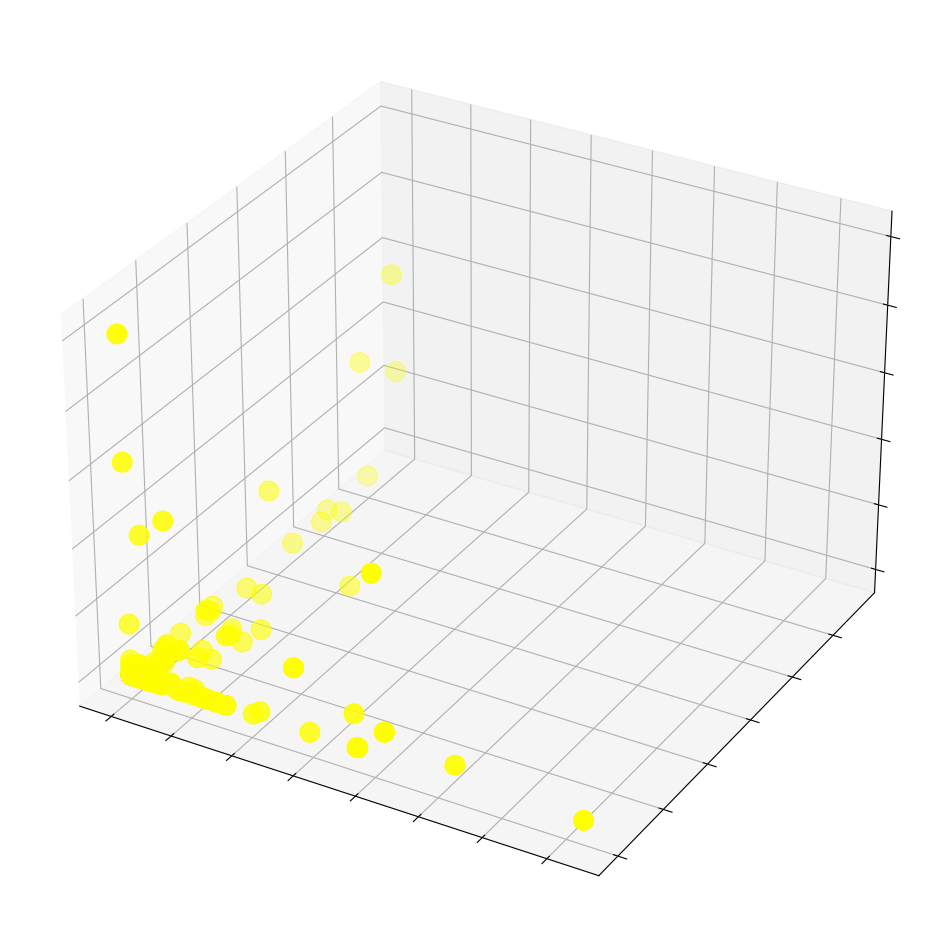

In [ ]:
# Get first embedding at epoch = 0
embed = emb.detach().cpu().numpy()

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.patch.set_alpha(0)
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
ax.scatter(embed[:, 1], embed[:, 2], embed[:, 3], s=200, c='yellow', cmap="hsv", vmin=-2, vmax=3)

plt.show()

In [ ]:
embed.shape

(10920, 3)

In [ ]:
len(data.ndata['label'])

2277

[0.         0.         0.01306752 0.        ]


In [ ]:
%%capture

def animate(i):
    embed = embeddings[i].detach().cpu().numpy()
    ax.clear()
    ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2],
           s=200, c=data.y, cmap="hsv", vmin=-2, vmax=3)
    plt.title(f'Epoch {i} | Loss: {losses[i]:.2f} | Acc: {accuracies[i]*100:.2f}%',
              fontsize=18, pad=40)

fig = plt.figure(figsize=(12, 12))
plt.axis('off')
ax = fig.add_subplot(projection='3d')
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)

anim = animation.FuncAnimation(fig, animate, \
              np.arange(0, 200, 10), interval=800, repeat=True)
html = HTML(anim.to_html5_video())

In [ ]:
display(html)

###4\. Сравнить точность GCN с другими моделями

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9001831501831502


<Axes: >

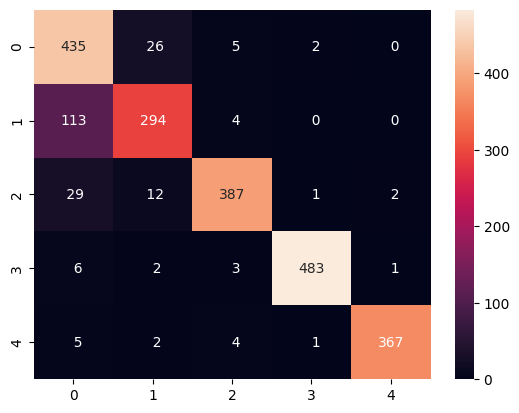

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_feat, train_label, test_size=0.2, random_state=42)

reg = LogisticRegression(max_iter=100).fit(X_train, y_train)
y_pred = reg.predict(X_test)
print(accuracy_score(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='3.0f')

0.842948717948718


<Axes: >

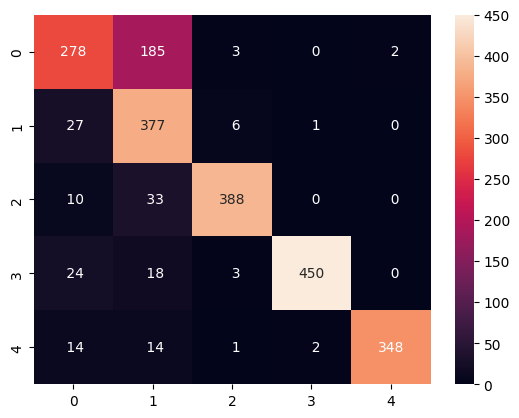

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
y_pred_nei = neigh.predict(X_test)
print(accuracy_score(y_test, y_pred_nei))
sns.heatmap(confusion_matrix(y_test, y_pred_nei), annot=True, fmt='3.0f')

In [ ]:
class FullyLinear(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(FullyLinear, self).__init__()
        self.fc_1 = Linear(num_features, 128)
        self.fc_2 = Linear(128, 32)
        self.fc_3 = Linear(32, num_classes)

    def forward(self, feat):
        out = self.fc_1(feat)
        out = self.fc_2(out)
        out = self.fc_3(out)
        return out

In [ ]:
model = FullyLinear(num_features=data.ndata['feat'].shape[1], num_classes=dataset.num_classes)
print(model)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)

# Data for animations
embeddings = []
losses = []
accuracies = []
outputs = []

for epoch in range(101):

    optimizer.zero_grad() # Clear gradients

    out = model(train_feat) # Forward pass
    loss = criterion(out, train_label) # Calculate loss function
    acc = accuracy(out.argmax(dim=1), train_label) # Calculate accuracy

    loss.backward() # Compute gradients
    optimizer.step() # Tune parameters

    # Store data for animations
    # embeddings.append(emb)
    losses.append(loss)
    accuracies.append(acc)
    outputs.append(out.argmax(dim=1))

    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss:.2f} | Acc: {acc*100:.2f}%')

FullyLinear(
  (fc_1): Linear(in_features=2325, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=32, bias=True)
  (fc_3): Linear(in_features=32, out_features=5, bias=True)
)
Epoch   0 | Loss: 1.62 | Acc: 20.31%
Epoch  10 | Loss: 0.39 | Acc: 85.52%
Epoch  20 | Loss: 0.19 | Acc: 92.46%
Epoch  30 | Loss: 0.15 | Acc: 93.38%
Epoch  40 | Loss: 0.14 | Acc: 93.64%
Epoch  50 | Loss: 0.14 | Acc: 93.62%
Epoch  60 | Loss: 0.14 | Acc: 93.60%
Epoch  70 | Loss: 0.14 | Acc: 93.75%
Epoch  80 | Loss: 0.14 | Acc: 93.65%
Epoch  90 | Loss: 0.14 | Acc: 93.74%
Epoch 100 | Loss: 0.14 | Acc: 93.69%


##lab_6 Рекуррентные графы


###2\.Реализовать на основе кода, представленного в статье, графовую рекурентную нейросеть (например, используя в качестве датасета текст в виде графа).


In [72]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes,
                 embed_dim=256, hid_dim=3, rnn_hid_dim=128):
        super(GCN, self).__init__()
        self.gcn = GraphConv(num_features, embed_dim, allow_zero_in_degree=True)
        self.bn1 = nn.BatchNorm1d(embed_dim)
        # self.conv = Conv1d(in_channels=embed_dim, out_channels=hid_dim, kernel_size=3, padding=1)
        self.rnn = RNN(embed_dim, rnn_hid_dim, num_layers=3)
        self.fc_1 = Linear(rnn_hid_dim, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc_2 = Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.fc_3 = Linear(32, num_classes)
        self.emb = None

    def forward(self, g, feat):
        self.emb = self.bn1(self.gcn(g, feat).relu())
        # emb = self.conv(emb.permute(1, 0)).relu()
        out, _ = self.rnn(self.emb.unsqueeze(1))
        out = self.bn2(self.fc_1(out[:, -1, :]).relu())
        out = self.bn3(self.fc_2(out).relu())
        out = self.fc_3(out)
        return out #.permute(1, 0), out

In [86]:
def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)

def train_me(num_epochs, model, graph, feat, label, optimizer, criterion):
    losses = []

    for epoch in range(num_epochs+1):

        optimizer.zero_grad()
        out = model(graph, feat)
        loss = criterion(out, label)
        losses.append(loss.detach().item())
        loss.backward()
        optimizer.step()

        acc = accuracy(out.argmax(dim=1), label)
        # if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss:.2f} | Acc: {acc*100:.2f}%')
    return losses

In [ ]:
# lr = 0.003 # локальный минимум лосс 1.61, 1.27
# num_epochs = 100

# model = GCN(num_features=data.ndata['feat'].shape[1], num_classes=dataset.num_classes)
# nn.init.xavier_normal_(model.fc_1.weight)
# nn.init.xavier_normal_(model.fc_2.weight)
# print(model)

# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# losses = train_me(num_epochs, model, train_graph, train_feat, train_label, optimizer, criterion)

GCN(
  (gcn): GraphConv(in=2325, out=128, normalization=both, activation=None)
  (rnn): RNN(128, 64, num_layers=3)
  (fc_1): Linear(in_features=64, out_features=32, bias=True)
  (fc_2): Linear(in_features=32, out_features=5, bias=True)
)
Epoch   0 | Loss: 1.64 | Acc: 16.78%
Epoch  10 | Loss: 1.57 | Acc: 26.03%
Epoch  20 | Loss: 1.52 | Acc: 29.01%
Epoch  30 | Loss: 1.45 | Acc: 30.69%
Epoch  40 | Loss: 1.39 | Acc: 32.68%
Epoch  50 | Loss: 1.39 | Acc: 36.79%
Epoch  60 | Loss: 1.32 | Acc: 38.19%
Epoch  70 | Loss: 1.33 | Acc: 35.18%
Epoch  80 | Loss: 1.30 | Acc: 39.12%
Epoch  90 | Loss: 1.29 | Acc: 36.77%
Epoch 100 | Loss: 1.28 | Acc: 39.51%


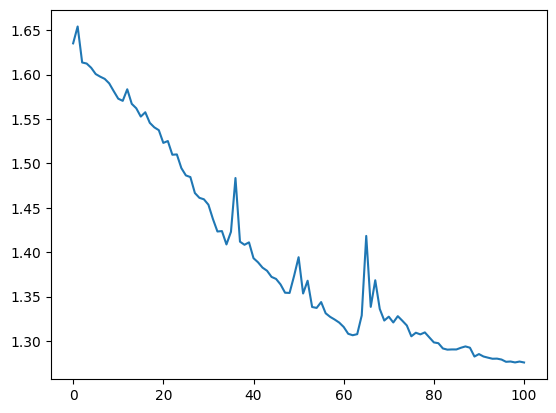

In [ ]:
# plt.plot(range(len(losses)), losses)

In [ ]:
# # model_path = "/content/drive/MyDrive/Colab_Notebooks/МОвСиСА/models/rnn_400.pt"

# model_path = "/content/drive/MyDrive/Colab_Notebooks/МОвСиСА/models/rnn_400bn.pt"
# torch.save(model.state_dict(), model_path)
# print("Model saved to:", model_path)

Model saved to: /content/drive/MyDrive/Colab_Notebooks/МОвСиСА/models/rnn_400.pt


In [78]:
lr = 0.037 # локальный минимум лосс 1.61, 1.27
num_epochs = 300

model = GCN(num_features=data.ndata['feat'].shape[1], num_classes=dataset.num_classes)
nn.init.xavier_normal_(model.fc_1.weight)
nn.init.xavier_normal_(model.fc_2.weight)
print(model)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

losses = train_me(num_epochs, model, train_graph, train_feat, train_label, optimizer, criterion)

GCN(
  (gcn): GraphConv(in=2325, out=256, normalization=both, activation=None)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rnn): RNN(256, 128, num_layers=3)
  (fc_1): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_2): Linear(in_features=64, out_features=32, bias=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_3): Linear(in_features=32, out_features=5, bias=True)
)
Epoch   0 | Loss: 1.73 | Acc: 22.65%
Epoch  10 | Loss: 1.61 | Acc: 22.57%
Epoch  20 | Loss: 1.60 | Acc: 22.94%
Epoch  30 | Loss: 1.60 | Acc: 23.51%
Epoch  40 | Loss: 1.59 | Acc: 23.96%


KeyboardInterrupt: 

In [ ]:
plt.plot(range(len(losses)), losses)

In [ ]:
# mmodel = GCN(num_features=data.ndata['feat'].shape[1], num_classes=dataset.num_classes)
# mmodel.load_state_dict(torch.load('/content/drive/MyDrive/Colab_Notebooks/МОвСиСА/models/rnn_400.pt'))
# lr = 0.005 # локальный минимум, лосс 1.61, 1.27
# num_epochs = 300

# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(mmodel.parameters(), lr=lr)

# llosses = train_me(num_epochs, mmodel, train_graph, train_feat, train_label, optimizer, criterion)

Epoch   0 | Loss: 1.28 | Acc: 36.91%
Epoch  10 | Loss: 1.59 | Acc: 26.26%
Epoch  20 | Loss: 1.48 | Acc: 28.29%
Epoch  30 | Loss: 1.44 | Acc: 30.71%
Epoch  40 | Loss: 1.39 | Acc: 35.32%
Epoch  50 | Loss: 1.36 | Acc: 36.67%
Epoch  60 | Loss: 1.33 | Acc: 37.75%
Epoch  70 | Loss: 1.31 | Acc: 35.91%
Epoch  80 | Loss: 1.30 | Acc: 39.01%
Epoch  90 | Loss: 1.29 | Acc: 36.64%
Epoch 100 | Loss: 1.28 | Acc: 39.28%
Epoch 110 | Loss: 1.28 | Acc: 39.36%
Epoch 120 | Loss: 1.28 | Acc: 39.42%


KeyboardInterrupt: 

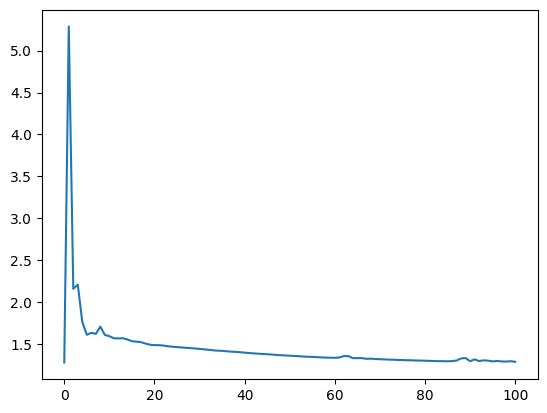

In [ ]:
plt.plot(range(len(llosses)), llosses)

In [81]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes,
                 embed_dim=256, hid_dim=3, rnn_hid_dim=128):
        super(GCN, self).__init__()
        # self.gcn = GraphConv(num_features, embed_dim, allow_zero_in_degree=True)
        # self.bn1 = nn.BatchNorm1d(embed_dim)
        # self.conv = Conv1d(in_channels=embed_dim, out_channels=hid_dim, kernel_size=3, padding=1)
        self.rnn = RNN(num_features, rnn_hid_dim, num_layers=3)
        self.fc_1 = Linear(rnn_hid_dim, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc_2 = Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.fc_3 = Linear(32, num_classes)
        self.emb = None

    def forward(self, g, feat):
        # self.emb = self.bn1(self.gcn(g, feat).relu())
        # emb = self.conv(emb.permute(1, 0)).relu()
        out, _ = self.rnn(feat.unsqueeze(1))
        out = self.bn2(self.fc_1(out[:, -1, :]).relu())
        out = self.bn3(self.fc_2(out).relu())
        out = self.fc_3(out)
        return out #.permute(1, 0), out

In [89]:
lr = 0.003 # локальный минимум лосс 1.61, 1.27
num_epochs = 10

model = GCN(num_features=data.ndata['feat'].shape[1], num_classes=dataset.num_classes)
nn.init.xavier_normal_(model.fc_1.weight)
nn.init.xavier_normal_(model.fc_2.weight)
print(model)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

losses = train_me(num_epochs, model, train_graph, train_feat, train_label, optimizer, criterion)

GCN(
  (rnn): RNN(2325, 128, num_layers=3)
  (fc_1): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_2): Linear(in_features=64, out_features=32, bias=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_3): Linear(in_features=32, out_features=5, bias=True)
)
Epoch   0 | Loss: 1.80 | Acc: 22.54%
Epoch   1 | Loss: 1.49 | Acc: 33.04%
Epoch   2 | Loss: 1.32 | Acc: 47.31%
Epoch   3 | Loss: 1.18 | Acc: 56.42%
Epoch   4 | Loss: 1.07 | Acc: 62.86%
Epoch   5 | Loss: 0.97 | Acc: 67.53%
Epoch   6 | Loss: 0.88 | Acc: 72.29%
Epoch   7 | Loss: 0.79 | Acc: 76.20%
Epoch   8 | Loss: 0.71 | Acc: 80.06%
Epoch   9 | Loss: 0.64 | Acc: 82.82%
Epoch  10 | Loss: 0.57 | Acc: 86.09%


In [90]:
losses

[1.79547917842865,
 1.4884417057037354,
 1.3165045976638794,
 1.1790121793746948,
 1.066498875617981,
 0.9670749306678772,
 0.8791974186897278,
 0.7940318584442139,
 0.7115662097930908,
 0.6372197270393372,
 0.5683417320251465]

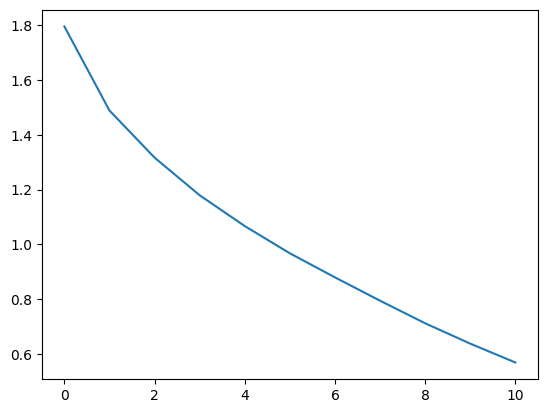

In [91]:
plt.plot(range(len(losses)), losses)

<Axes: >

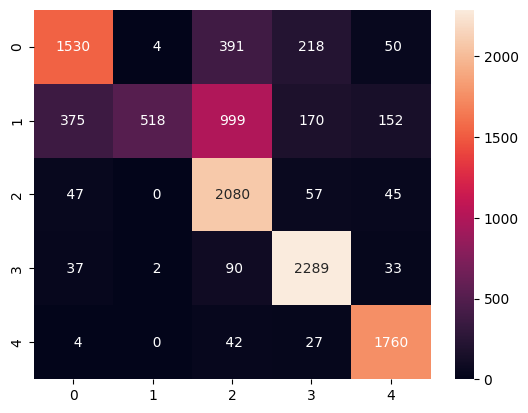

In [94]:
model.eval()
with torch.no_grad():

    y_pred = model(train_graph, train_feat).argmax(dim=1)

sns.heatmap(confusion_matrix(train_label, y_pred), annot=True, fmt='3.0f')

In [ ]:
# dataset = TensorDataset(train_feat, train_label)
# train_size = int(len(dataset) * 0.8)
# test_size = len(dataset) - train_size

# batch_size = 16

# train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])

# train_loader = DataLoader(train_set, batch_size, drop_last=True)
# test_loader = DataLoader(test_set, batch_size, drop_last=True)

In [ ]:
# def train_me(train_loader, graph, num_epochs, model, optimizer, criterion):
#     losses_avg = []

#     for epoch in tqdm(range(num_epochs+1)):
#         losses = []
#         for x_batch, y_batch in train_loader:
#             x_batch, y_batch = x_batch.to(device), y_batch.to(device)
#             y_pred = model(graph, x_batch)
#             curr_loss = criterion(y_pred, y_batch)
#             losses.append(curr_loss.item())
#             curr_loss.backward()
#             optimizer.step()
#             optimizer.zero_grad()

#         losses_avg.append(sum(losses) / len(losses))

#         if epoch % 10 == 0:
#             print(f'Epoch {epoch:>3} | Loss: {losses_avg[-1]:.2f}')

In [ ]:
# lr = 0.05
# num_epochs = 300

# model = GCN(num_features=data.ndata['feat'].shape[1], num_classes=len(train_label))
# model.to(device)
# print(model)

# criterion = torch.nn.CrossEntropyLoss().to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# train_me(train_loader, train_graph, num_epochs, model, optimizer, criterion)